# Code Generator

This noteboook uses Open Source model to generate high performance C++ code from Python code

For this we start a HuggingFace endpoint.

In [1]:
# imports

import os
import io
import sys
import json
import requests
from dotenv import load_dotenv
from openai import OpenAI
import google.generativeai
import anthropic
from IPython.display import Markdown, display, update_display
import gradio as gr
import subprocess

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# initialize

openai = OpenAI()
claude = anthropic.Anthropic()
OPENAI_MODEL = "gpt-4o"
CLAUDE_MODEL = "claude-opus-4-1-20250805"

In [4]:
system_message = "You are an assistant that reimplements Python code in high performance C++ for an M1 Mac. "
system_message += "Respond only with C++ code; use comments sparingly and do not provide any explanation other than occasional comments. "
system_message += "The C++ response needs to produce an identical output in the fastest possible time. Keep implementations of random number generators identical so that results match exactly."

In [5]:
def user_prompt_for(python):
    user_prompt = "Rewrite this Python code in C++ with the fastest possible implementation that produces identical output in the least time. "
    user_prompt += "Respond only with C++ code; do not explain your work other than a few comments. "
    user_prompt += "Pay attention to number types to ensure no int overflows. Remember to #include all necessary C++ packages such as iomanip.\n\n"
    user_prompt += python
    return user_prompt

In [6]:
def messages_for(python):
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt_for(python)}
    ]

In [7]:
# write to a file called optimized.cpp

def write_output(cpp):
    code = cpp.replace("```cpp","").replace("```","")
    with open("optimized.cpp", "w") as f:
        f.write(code)

In [8]:
def optimize_gpt(python):    
    stream = openai.chat.completions.create(model=OPENAI_MODEL, messages=messages_for(python), stream=True)
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        print(fragment, end='', flush=True)
    write_output(reply)

In [9]:
def optimize_claude(python):
    result = claude.messages.stream(
        model=CLAUDE_MODEL,
        max_tokens=2000,
        system=system_message,
        messages=[{"role": "user", "content": user_prompt_for(python)}],
    )
    reply = ""
    with result as stream:
        for text in stream.text_stream:
            reply += text
            print(text, end="", flush=True)
    write_output(reply)

In [20]:
pi = """
import time

def calculate(iterations, param1, param2):
    result = 1.0
    for i in range(1, iterations+1):
        j = i * param1 - param2
        result -= (1/j)
        j = i * param1 + param2
        result += (1/j)
    return result

start_time = time.time()
result = calculate(100_000_000, 4, 1) * 4
end_time = time.time()

print(f"Result: {result:.12f}")
print(f"Execution Time: {(end_time - start_time):.6f} seconds")
"""

In [10]:
python_hard = """# Be careful to support large number sizes

def lcg(seed, a=1664525, c=1013904223, m=2**32):
    value = seed
    while True:
        value = (a * value + c) % m
        yield value
        
def max_subarray_sum(n, seed, min_val, max_val):
    lcg_gen = lcg(seed)
    random_numbers = [next(lcg_gen) % (max_val - min_val + 1) + min_val for _ in range(n)]
    max_sum = float('-inf')
    for i in range(n):
        current_sum = 0
        for j in range(i, n):
            current_sum += random_numbers[j]
            if current_sum > max_sum:
                max_sum = current_sum
    return max_sum

def total_max_subarray_sum(n, initial_seed, min_val, max_val):
    total_sum = 0
    lcg_gen = lcg(initial_seed)
    for _ in range(20):
        seed = next(lcg_gen)
        total_sum += max_subarray_sum(n, seed, min_val, max_val)
    return total_sum

# Parameters
n = 10000         # Number of random numbers
initial_seed = 42 # Initial seed for the LCG
min_val = -10     # Minimum value of random numbers
max_val = 10      # Maximum value of random numbers

# Timing the function
import time
start_time = time.time()
result = total_max_subarray_sum(n, initial_seed, min_val, max_val)
end_time = time.time()

print("Total Maximum Subarray Sum (20 runs):", result)
print("Execution Time: {:.6f} seconds".format(end_time - start_time))
"""

In [11]:
def stream_gpt(python):    
    stream = openai.chat.completions.create(model=OPENAI_MODEL, messages=messages_for(python), stream=True)
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        yield reply.replace('```cpp\n','').replace('```','')

In [12]:
def stream_claude(python):
    result = claude.messages.stream(
        model=CLAUDE_MODEL,
        max_tokens=2000,
        system=system_message,
        messages=[{"role": "user", "content": user_prompt_for(python)}],
    )
    reply = ""
    with result as stream:
        for text in stream.text_stream:
            reply += text
            yield reply.replace('```cpp\n','').replace('```','')

In [14]:
def execute_python(code):
    try:
        output = io.StringIO()
        sys.stdout = output
        exec(code)
    finally:
        sys.stdout = sys.__stdout__
    return output.getvalue()

In [15]:
def execute_cpp(code):
    write_output(code)
    compiler_cmd = ["clang++", "-O3", "-std=c++17", "-march=armv8.3-a", "-o", "optimized", "optimized.cpp"]
    try:
        compile_result = subprocess.run(compiler_cmd, check=True, text=True, capture_output=True)
        run_cmd = ["./optimized"]
        run_result = subprocess.run(run_cmd, check=True, text=True, capture_output=True)
        return run_result.stdout
    except subprocess.CalledProcessError as e:
        return f"An error occurred:\n{e.stderr}"

In [41]:
css = """
.python {background-color: #306998;}
.cpp {background-color: #050;}
"""

In [16]:
from huggingface_hub import login, InferenceClient
from transformers import AutoTokenizer

In [44]:
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [55]:
code_qwen = "Qwen/CodeQwen1.5-7B-Chat"
# code_gemma = "google/codegemma-7b-it"
CODE_QWEN_URL = "https://ext3ptnwfe98dzn3.us-east-1.aws.endpoints.huggingface.cloud"#"https://h1vdol7jxhje3mpn.us-east-1.aws.endpoints.huggingface.cloud"
# CODE_GEMMA_URL = "https://c5hggiyqachmgnqg.us-east-1.aws.endpoints.huggingface.cloud"

In [56]:
tokenizer = AutoTokenizer.from_pretrained(code_qwen)
messages = messages_for(pi)
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

In [57]:
tokenizer = AutoTokenizer.from_pretrained(code_qwen)
messages = messages_for(pi)
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

In [61]:
print(text)

In [58]:
text

'<|im_start|>system\nYou are an assistant that reimplements Python code in high performance C++ for an M1 Mac. Respond only with C++ code; use comments sparingly and do not provide any explanation other than occasional comments. The C++ response needs to produce an identical output in the fastest possible time. Keep implementations of random number generators identical so that results match exactly.<|im_end|>\n<|im_start|>user\nRewrite this Python code in C++ with the fastest possible implementation that produces identical output in the least time. Respond only with C++ code; do not explain your work other than a few comments. Pay attention to number types to ensure no int overflows. Remember to #include all necessary C++ packages such as iomanip.\n\n\nimport time\n\ndef calculate(iterations, param1, param2):\n    result = 1.0\n    for i in range(1, iterations+1):\n        j = i * param1 - param2\n        result -= (1/j)\n        j = i * param1 + param2\n        result += (1/j)\n    re

In [63]:
client = InferenceClient(CODE_QWEN_URL, token=hf_token)
stream = client.text_generation(text, stream=True, details=True, max_new_tokens=3000)
print(f"Starting generation with text: {text[:100]}")
for r in stream:
    print(r.token.text, end = "")

In [64]:
def stream_code_qwen(python):
    tokenizer = AutoTokenizer.from_pretrained(code_qwen)
    messages = messages_for(python)
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    client = InferenceClient(CODE_QWEN_URL, token=hf_token)
    stream = client.text_generation(text, stream=True, details=True, max_new_tokens=3000)
    result = ""
    for r in stream:
        result += r.token.text
        yield result    

In [65]:
def optimize(python, model):
    if model=="GPT":
        result = stream_gpt(python)
    elif model=="Claude":
        result = stream_claude(python)
    elif model=="CodeQwen":
        result = stream_code_qwen(python)
    else:
        raise ValueError("Unknown model")
    for stream_so_far in result:
        yield stream_so_far    

In [66]:
def select_sample_program(sample_program):
    if sample_program=="pi":
        return pi
    elif sample_program=="python_hard":
        return python_hard
    else:
        return "Type your Python program here"

In [67]:
import platform

VISUAL_STUDIO_2022_TOOLS = "C:\\Program Files\\Microsoft Visual Studio\\2022\\Community\\Common7\Tools\\VsDevCmd.bat"
VISUAL_STUDIO_2019_TOOLS = "C:\\Program Files (x86)\\Microsoft Visual Studio\\2019\\BuildTools\\Common7\\Tools\\VsDevCmd.bat"

simple_cpp = """
#include <iostream>

int main() {
    std::cout << "Hello";
    return 0;
}
"""

def run_cmd(command_to_run):
    try:
        run_result = subprocess.run(command_to_run, check=True, text=True, capture_output=True)
        return run_result.stdout if run_result.stdout else "SUCCESS"
    except:
        return ""

def c_compiler_cmd(filename_base):
    my_platform = platform.system()
    my_compiler = []

    try:
        with open("simple.cpp", "w") as f:
            f.write(simple_cpp)
            
        if my_platform == "Windows":
            if os.path.isfile(VISUAL_STUDIO_2022_TOOLS):
                if os.path.isfile("./simple.exe"):
                    os.remove("./simple.exe")
                compile_cmd = ["cmd", "/c", VISUAL_STUDIO_2022_TOOLS, "&", "cl", "simple.cpp"]
                if run_cmd(compile_cmd):
                    if run_cmd(["./simple.exe"]) == "Hello":
                        my_compiler = ["Windows", "Visual Studio 2022", ["cmd", "/c", VISUAL_STUDIO_2022_TOOLS, "&", "cl", f"{filename_base}.cpp"]]
        
            if not my_compiler:
                if os.path.isfile(VISUAL_STUDIO_2019_TOOLS):
                    if os.path.isfile("./simple.exe"):
                        os.remove("./simple.exe")
                    compile_cmd = ["cmd", "/c", VISUAL_STUDIO_2019_TOOLS, "&", "cl", "simple.cpp"]
                    if run_cmd(compile_cmd):
                        if run_cmd(["./simple.exe"]) == "Hello":
                            my_compiler = ["Windows", "Visual Studio 2019", ["cmd", "/c", VISUAL_STUDIO_2019_TOOLS, "&", "cl", f"{filename_base}.cpp"]]
    
            if not my_compiler:
                my_compiler=[my_platform, "Unavailable", []]
                
        elif my_platform == "Linux":
            if os.path.isfile("./simple"):
                os.remove("./simple")
            compile_cmd = ["g++", "simple.cpp", "-o", "simple"]
            if run_cmd(compile_cmd):
                if run_cmd(["./simple"]) == "Hello":
                    my_compiler = ["Linux", "GCC (g++)", ["g++", f"{filename_base}.cpp", "-o", f"{filename_base}" ]]
    
            if not my_compiler:
                if os.path.isfile("./simple"):
                    os.remove("./simple")
                compile_cmd = ["clang++", "simple.cpp", "-o", "simple"]
                if run_cmd(compile_cmd):
                    if run_cmd(["./simple"]) == "Hello":
                        my_compiler = ["Linux", "Clang++", ["clang++", f"{filename_base}.cpp", "-o", f"{filename_base}"]]
        
            if not my_compiler:
                my_compiler=[my_platform, "Unavailable", []]
    
        elif my_platform == "Darwin":
            if os.path.isfile("./simple"):
                os.remove("./simple")
            compile_cmd = ["clang++", "-Ofast", "-std=c++17", "-march=armv8.5-a", "-mtune=apple-m1", "-mcpu=apple-m1", "-o", "simple", "simple.cpp"]
            if run_cmd(compile_cmd):
                if run_cmd(["./simple"]) == "Hello":
                    my_compiler = ["Macintosh", "Clang++", ["clang++", "-Ofast", "-std=c++17", "-march=armv8.5-a", "-mtune=apple-m1", "-mcpu=apple-m1", "-o", f"{filename_base}", f"{filename_base}.cpp"]]
    
            if not my_compiler:
                my_compiler=[my_platform, "Unavailable", []]
    except:
        my_compiler=[my_platform, "Unavailable", []]
        
    if my_compiler:
        return my_compiler
    else:
        return ["Unknown", "Unavailable", []]


In [68]:
compiler_cmd = c_compiler_cmd("optimized")

with gr.Blocks(css=css) as ui:
    gr.Markdown("## Convert code from Python to C++")
    with gr.Row():
        python = gr.Textbox(label="Python code:", value=python_hard, lines=10)
        cpp = gr.Textbox(label="C++ code:", lines=10)
    with gr.Row():
        with gr.Column():
            sample_program = gr.Radio(["pi", "python_hard"], label="Sample program", value="python_hard")
            model = gr.Dropdown(["GPT", "Claude", "CodeQwen"], label="Select model", value="GPT")
        with gr.Column():
            architecture = gr.Radio([compiler_cmd[0]], label="Architecture", interactive=False, value=compiler_cmd[0])
            compiler = gr.Radio([compiler_cmd[1]], label="Compiler", interactive=False, value=compiler_cmd[1])
    with gr.Row():
        convert = gr.Button("Convert code")
    with gr.Row():
        python_run = gr.Button("Run Python")
        if not compiler_cmd[1] == "Unavailable":
            cpp_run = gr.Button("Run C++")
        else:
            cpp_run = gr.Button("No compiler to run C++", interactive=False)
    with gr.Row():
        python_out = gr.TextArea(label="Python result:", elem_classes=["python"])
        cpp_out = gr.TextArea(label="C++ result:", elem_classes=["cpp"])

    sample_program.change(select_sample_program, inputs=[sample_program], outputs=[python])
    convert.click(optimize, inputs=[python, model], outputs=[cpp])
    python_run.click(execute_python, inputs=[python], outputs=[python_out])
    cpp_run.click(execute_cpp, inputs=[cpp], outputs=[cpp_out])

ui.launch(inbrowser=True)

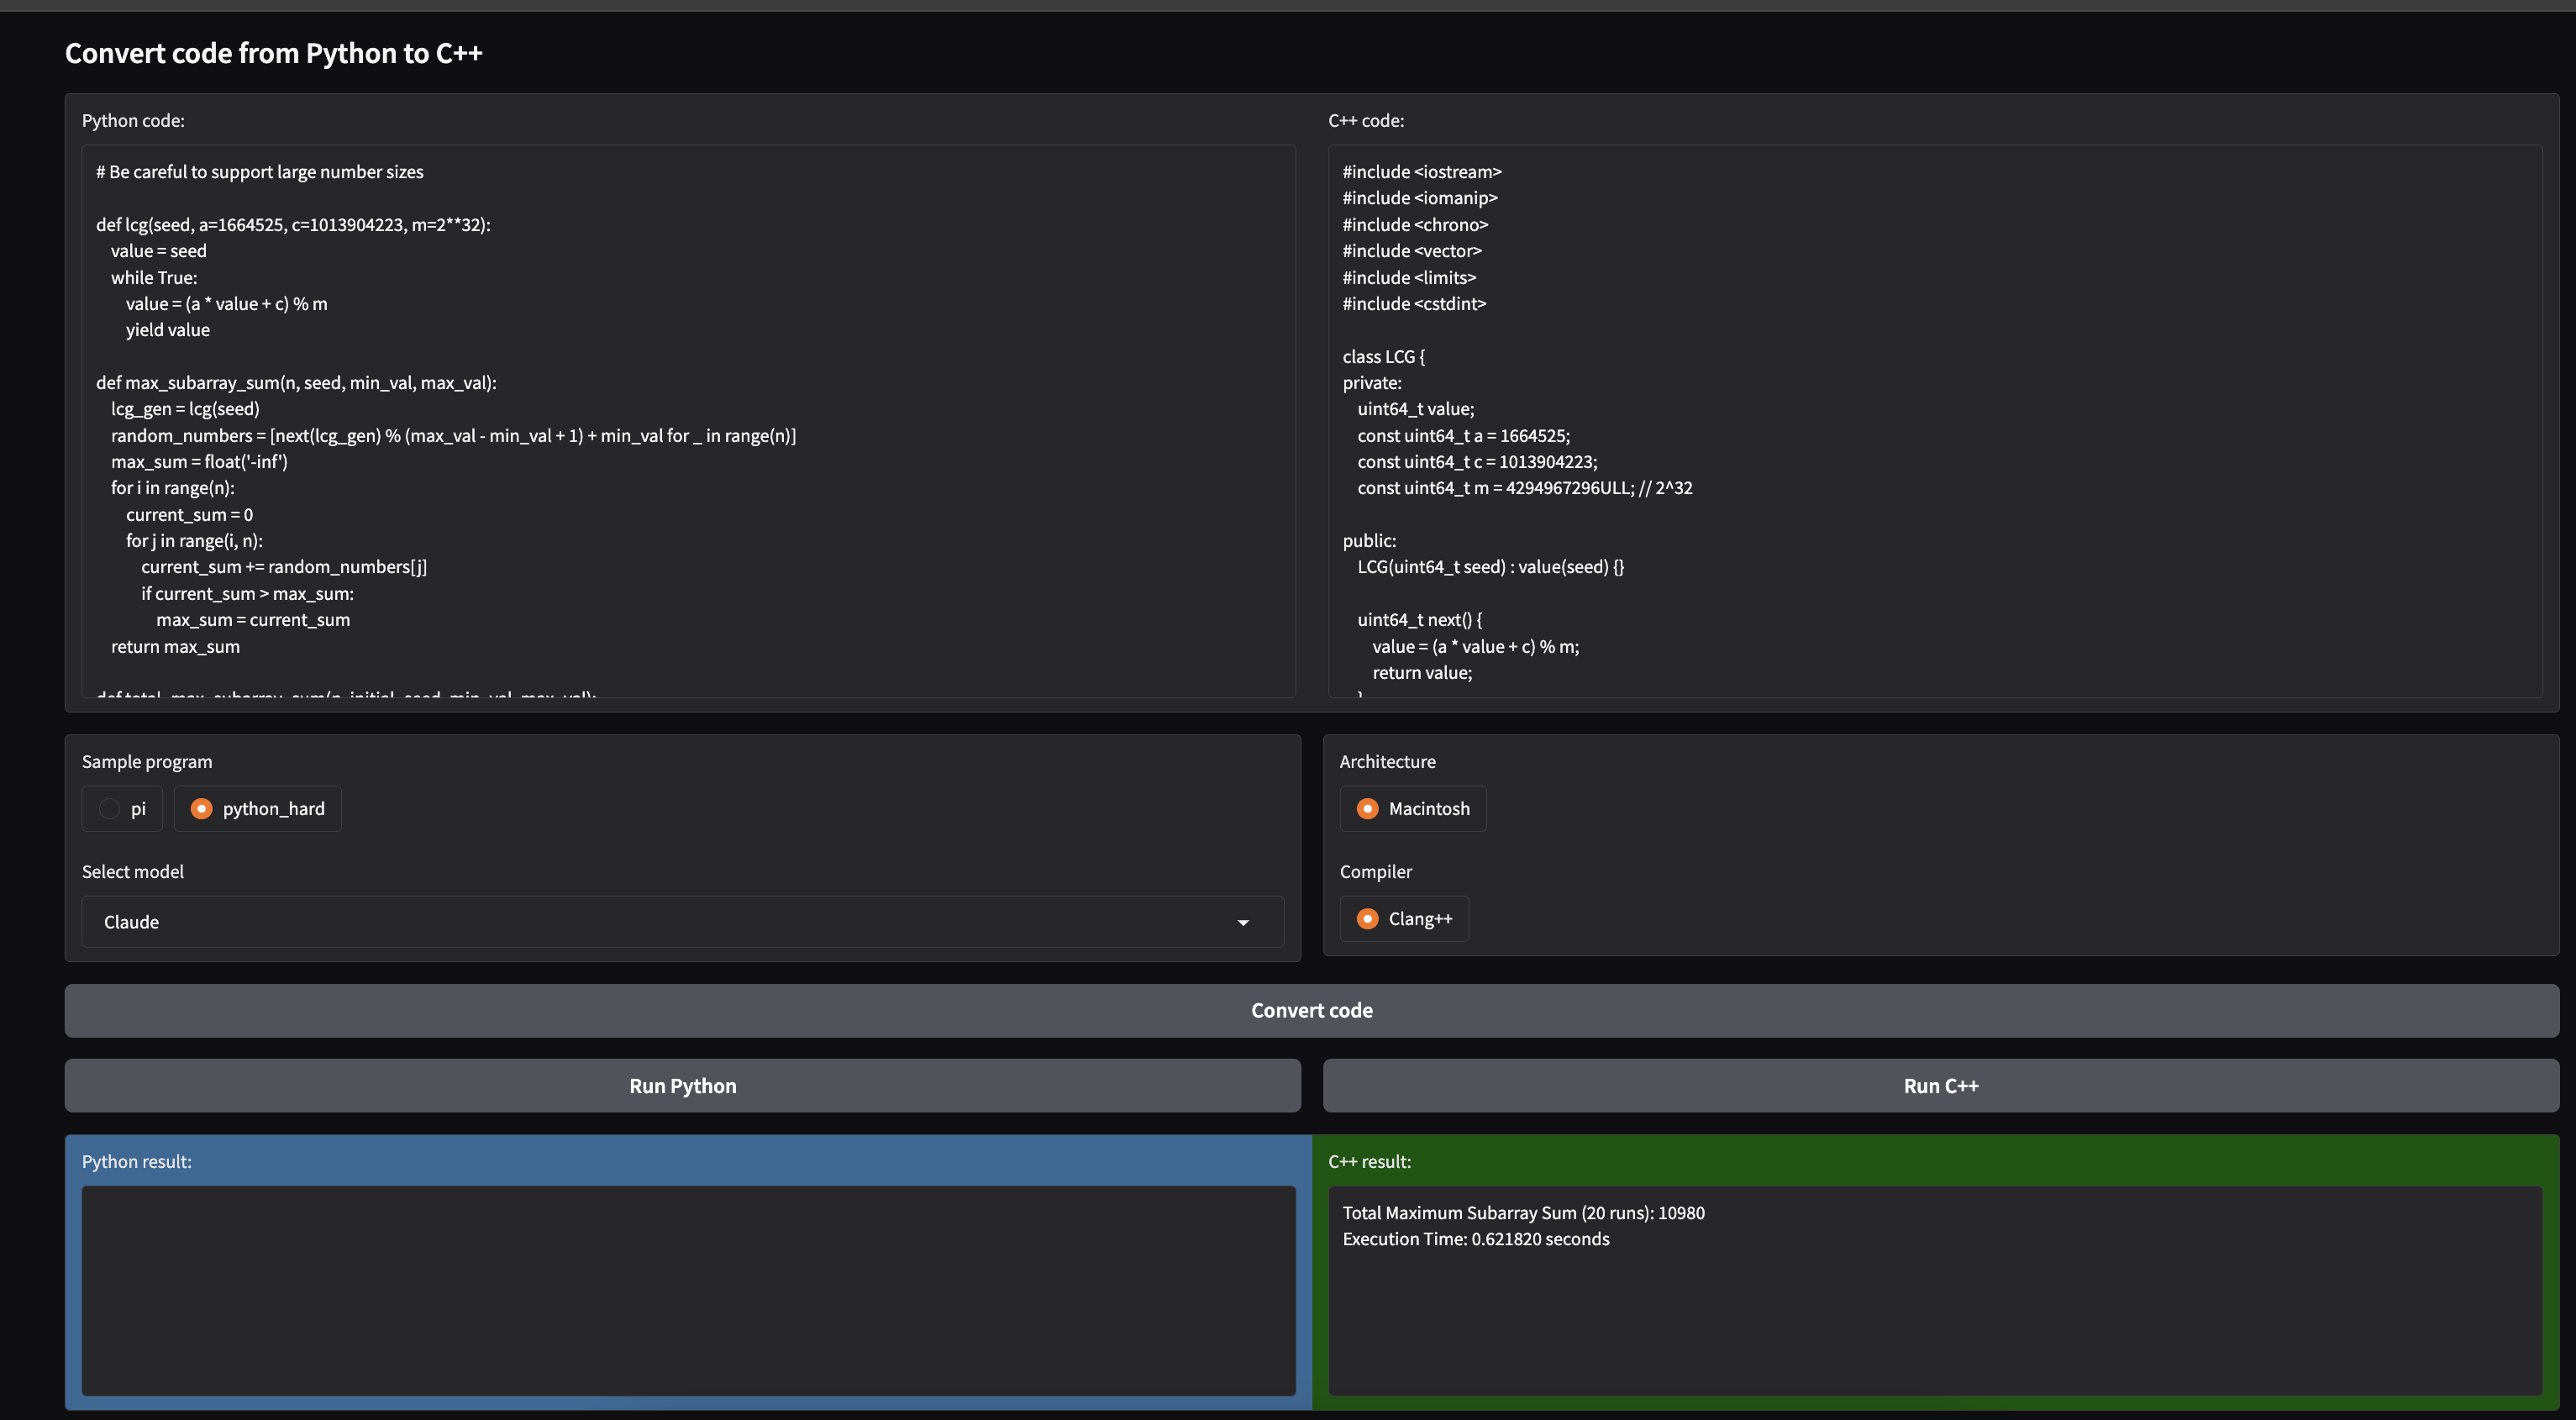

In [71]:
from IPython.display import Image, display

display(Image(filename="/Users/shreyagupta/projects/deep-llm-engineering/images/convert_hard_python_code_using_qwen.png"))

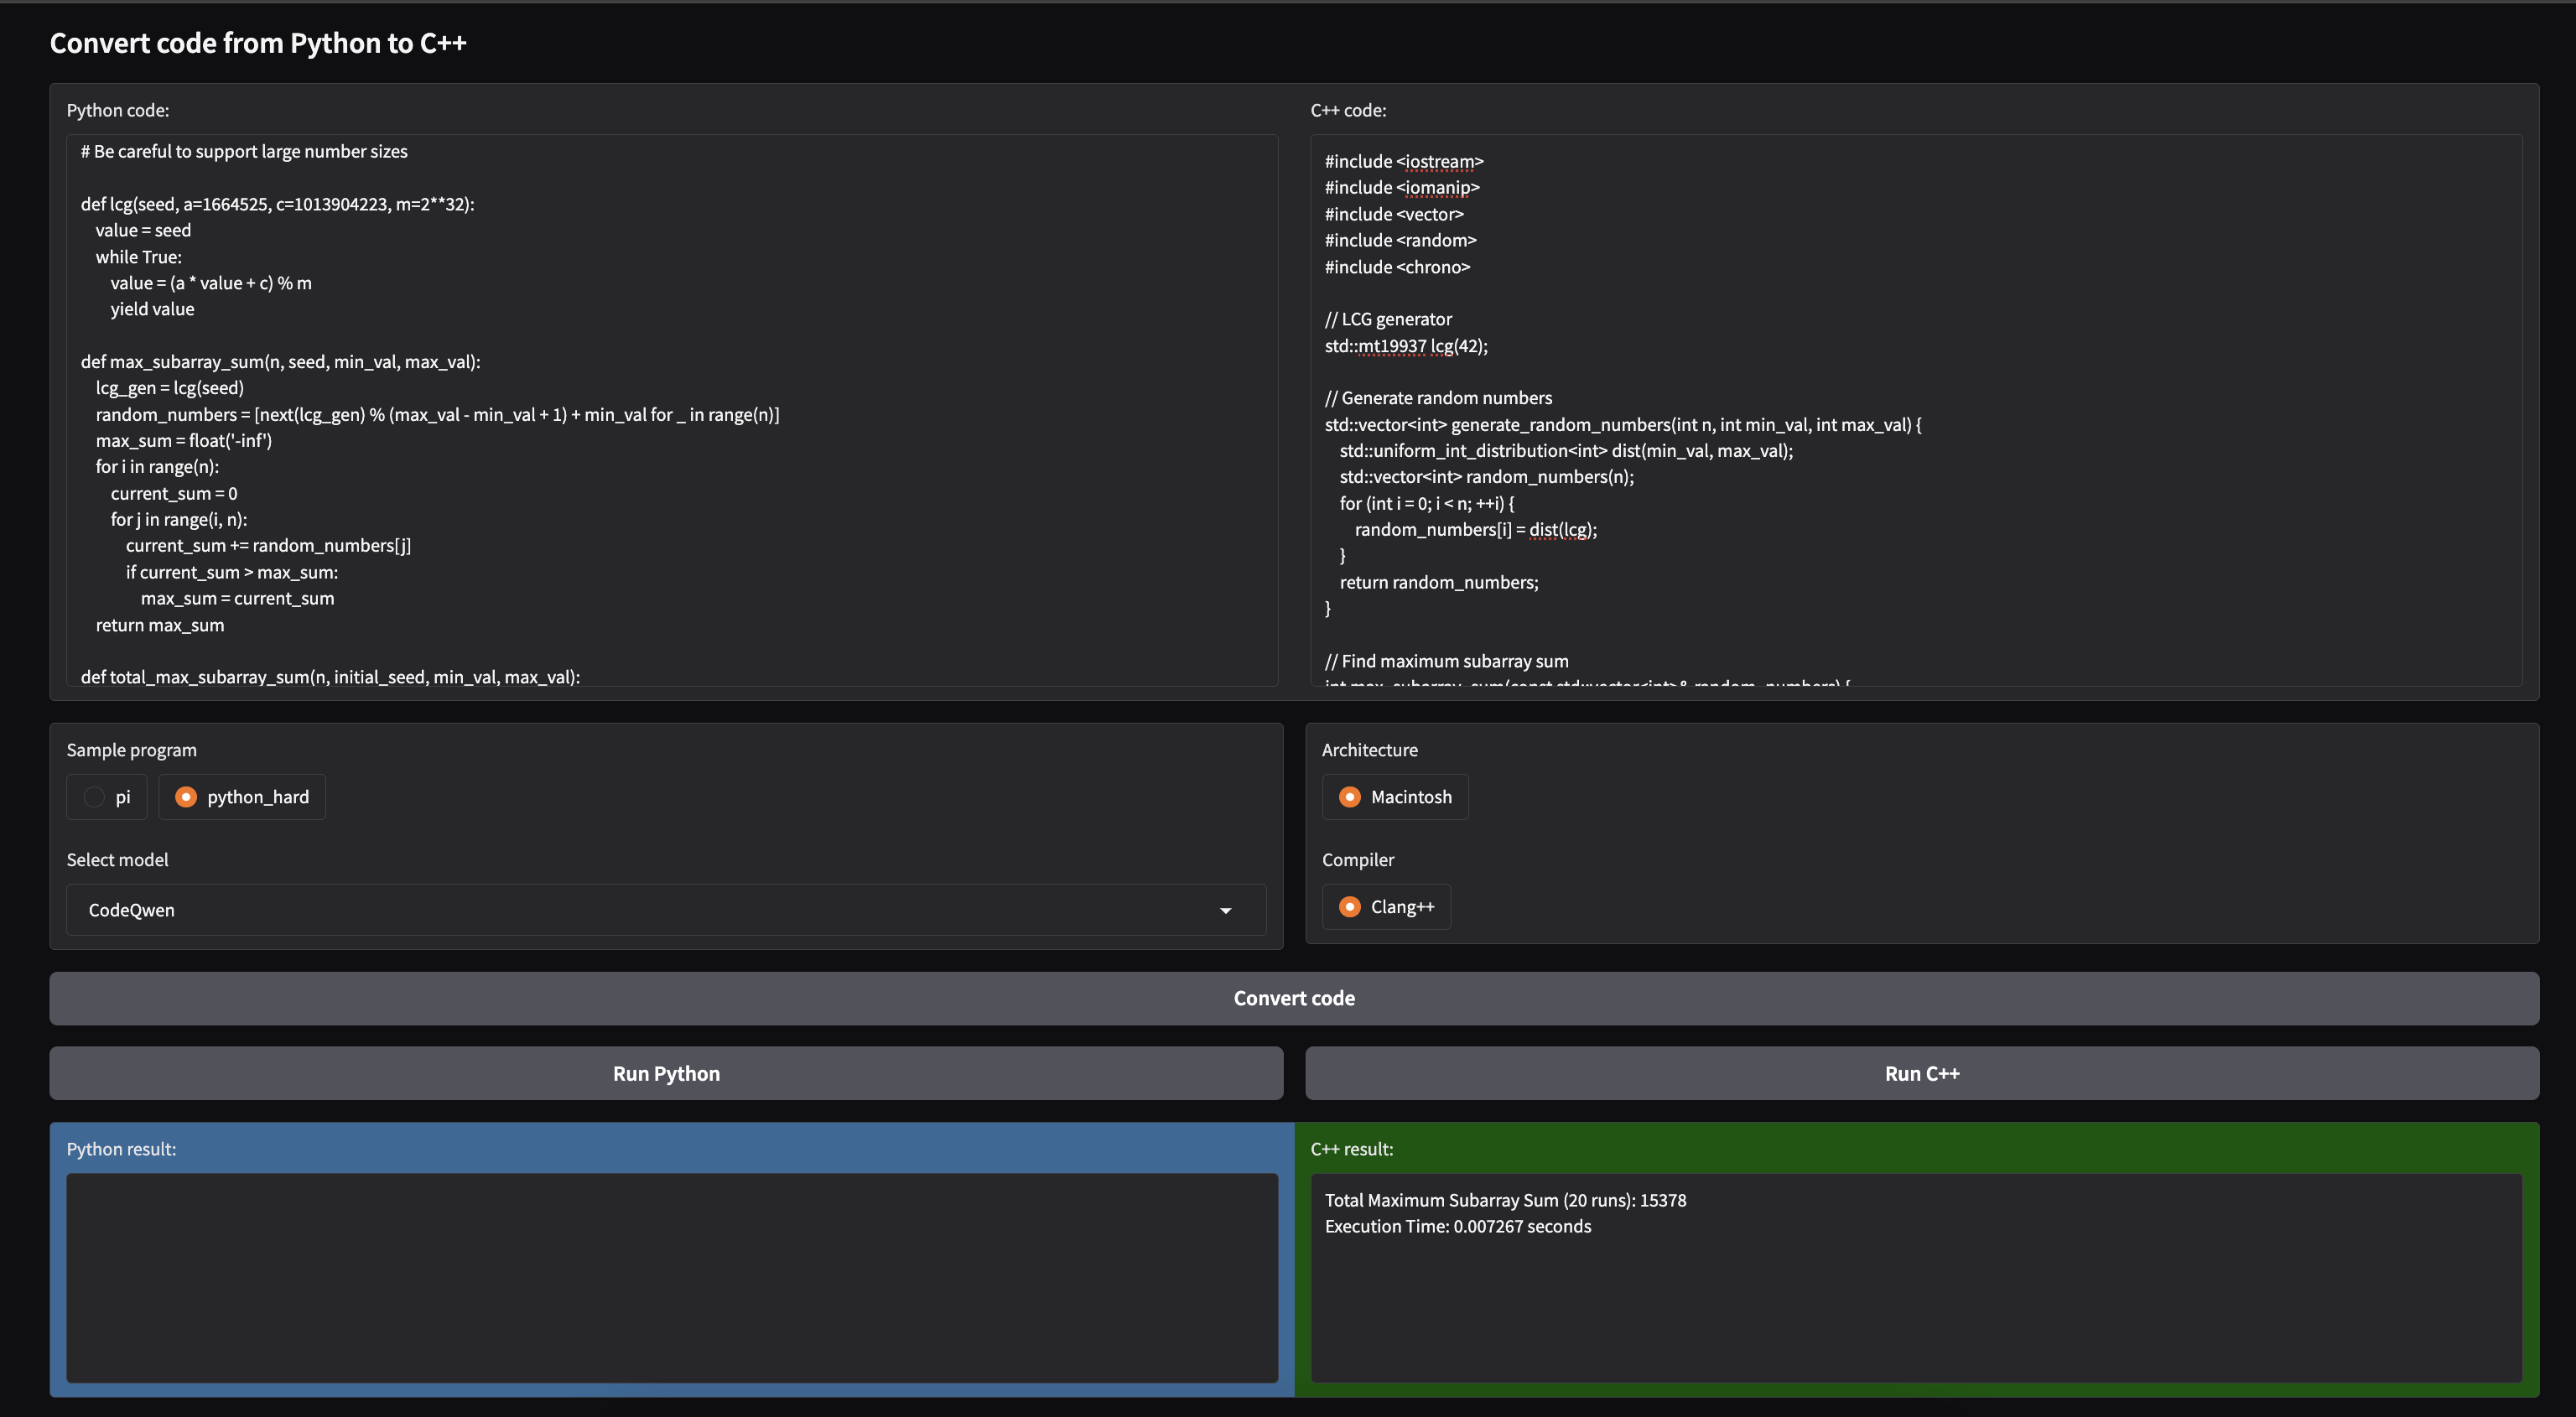

In [72]:
display(Image(filename="/Users/shreyagupta/projects/deep-llm-engineering/images/convert_hard_python_code_using_claude.png"))